[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/supervised.ipynb)

# Guiding Embeddings by Correlation

This example is very similar to the [Supervised DR example](supervised.rst).
There, we definde a triplet loss that was based on the class labels. Here, we are going to define a loss that constrains the embedding based on one of the original, high-dimensional data attributes. In particular, we will make one of the embedding coordinates _correlate_ with one selected data attribute.

## Data Preprocessing

First we will set up our training data. This part is the same as in the [Supervised DR example](supervised.rst).

In [2]:
import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold
import sklearn.preprocessing
from matplotlib import pyplot as plt

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.utils

paradime.utils.seed.seed_all(42);

covertype = sklearn.datasets.fetch_covtype()

label_to_name = {
    1: "Spruce/fir",
    2: "Lodgepole pine",
    3: "Ponderosa pine",
    4: "Cottonwood/willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}

_, counts = np.unique(covertype.target, return_counts=True)
weights = np.array([ 1/counts[i-1] for i in covertype.target ])

indices = list(torch.utils.data.WeightedRandomSampler(weights, 7000))

raw_data = covertype.data[indices,:10]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(raw_data)
data = scaler.transform(raw_data)

# Relations and Derived Data

Now we set up the relations and the derived data entry necessary for PCA initialization. Again, this part is exactly the same as in the [Supervised DR example](supervised.rst).

In [3]:
tsne_global_rel = paradime.relations.NeighborBasedPDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=200, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)

tsne_batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)

def pca(x):
    return sklearn.decomposition.PCA(n_components=2).fit_transform(x)

derived = paradime.dr.DerivedData(pca)

## Custom Loss

We can now define the correlation-based custom loss. The [Loss](../api/modules.rst#paradime.loss.Loss) has a forward function that expects a certain call signature.
We simply select the respective dimensions of the low- and high-dimensional data and compute the correlation between them.

In [4]:
class GuidingLoss(paradime.loss.Loss):
    """Triplet loss for supervised DR.

    This loss constrains an embedding in such a way that the specified
    dimension of the embedding correlates with the specified high-dimensional
    data attribute.

    Args:
        attr_index: The index of the high-dimensional data attribute.
        emb_dim: The index of the embedding dimension.
    """

    def __init__(self, attr_index, emb_dim, data_key="main", name=None):
        super().__init__(name)

        self.attr_index = attr_index
        self.emb_dim = emb_dim
        self.data_key = data_key

    def forward(self, model, global_relations, batch_relations, batch, device):

        data = batch[self.data_key].to(device)
        emb = model.embed(data)

        chosen_attr = data[:, self.attr_index]
        chosen_emb_coord = emb[:, self.emb_dim]

        # the following lines implement Pearson's correlation coefficient
        # in a differentiable way

        cov = torch.cov(
            torch.stack((chosen_attr, chosen_emb_coord))
        )

        corr = cov[0,1] / (chosen_attr.std() * chosen_emb_coord.std())

        # the actual loss is 1 minus the squared correlation

        loss = 1 - corr**2

        return loss

## Setting up the Routine

We can now set up the routine in the same way as we did in the [Supervised DR example](supervised.rst). We just define a dict of all our losses and combine them by passing several `loss_keys` to the embedding training phase.

In this example we make the _x_-coordinate of the embedding (index 0) correlate with the "Hillshade (noon)" attribute of the data (index 7).

In [5]:
losses = {
    "init": paradime.loss.PositionLoss(position_key="pca"),
    "embedding": paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div,
    ),
    "guiding": GuidingLoss(7, 0),
}

We then set up training phases for the PCA initialization and for the actual embedding. In this example we are going to train multiple routines with different weights on the losses. To make things easier, we define a function that sets up the guided embedding phase for us.

In [6]:
tsne_init = paradime.dr.TrainingPhase(
    name="pca_init",
    loss_keys=["init"],
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)

def guided_phase(w):

    weights = [w if w != -1 else 1, 1 if w != -1 else 0]

    return paradime.dr.TrainingPhase(
        name="embedding",
        loss_keys=["embedding", "guiding"],
        loss_weights=weights,
        batch_size=500,
        epochs=40,
        learning_rate=0.02,
        report_interval=2,
)

Now we can run our experiment for a given set of weights:

In [7]:
weights = [-1, 5000, 1000, 100]
routines = []

for w in weights:
    super_tsne = paradime.dr.ParametricDR(
        global_relations=tsne_global_rel,
        batch_relations=tsne_batch_rel,
        derived_data={"pca": derived},
        losses=losses,
        in_dim=10,
        out_dim=2,
        hidden_dims=[100, 50],
        use_cuda=True,
        verbose=True,
    )
    super_tsne.add_training_phase(tsne_init)
    super_tsne.add_training_phase(guided_phase(w))
    super_tsne.train(data)

    routines.append(super_tsne)

2022-12-05 16:17:02,044: Initializing training dataset.
2022-12-05 16:17:02,046: Computing derived data entry 'pca'.
2022-12-05 16:17:02,061: Adding entry 'pca' to dataset.
2022-12-05 16:17:02,063: Computing global relations 'rel'.
2022-12-05 16:17:02,064: Indexing nearest neighbors.
2022-12-05 16:17:32,098: Calculating probabilities.
2022-12-05 16:17:33,613: Beginning training phase 'pca_init'.
2022-12-05 16:17:35,198: Loss after epoch 0: 11.940744780004025
2022-12-05 16:17:35,582: Loss after epoch 5: 0.014664343849290162
2022-12-05 16:17:36,051: Beginning training phase 'embedding'.
2022-12-05 16:17:38,762: Loss after epoch 0: 0.05023368517868221
2022-12-05 16:17:44,476: Loss after epoch 2: 0.04354730644263327
2022-12-05 16:17:50,155: Loss after epoch 4: 0.04269229085184634
2022-12-05 16:17:55,923: Loss after epoch 6: 0.042116038501262665
2022-12-05 16:18:01,720: Loss after epoch 8: 0.041533354902639985
2022-12-05 16:18:07,597: Loss after epoch 10: 0.04116497584618628
2022-12-05 16:1

## Visualizing the Results

Let's now visualize the results and see how the correlation loss affects the embedding. This time, we'll color the scatterplot by the data attribute that we chose for our loss (hillshade at noon).

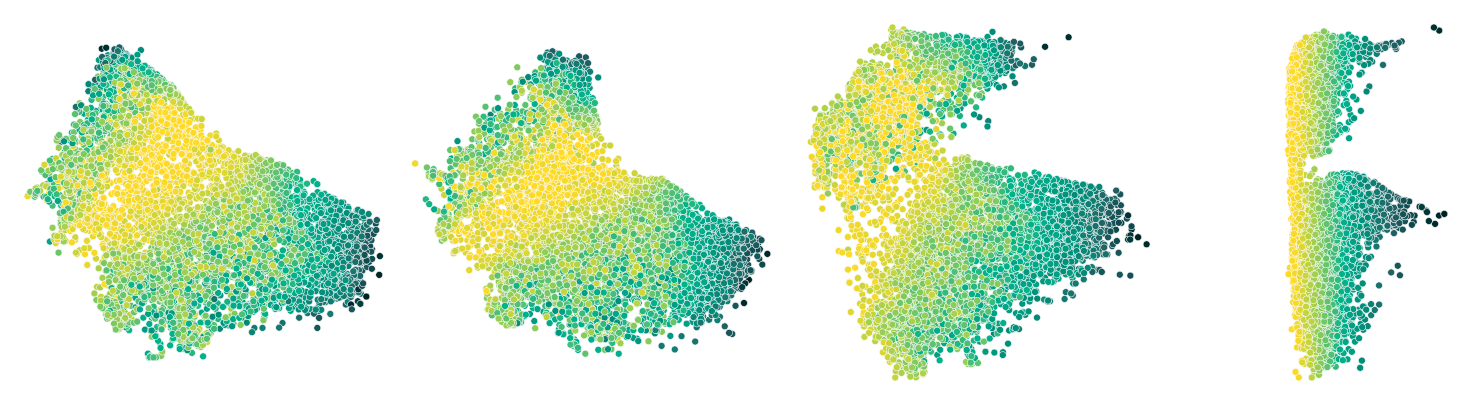

In [8]:
fig = plt.figure(figsize=(20,5))
for i, r in enumerate(routines):
    ax = fig.add_subplot(1,len(routines), i + 1)
    # ax.set_title(weights[j])
    paradime.utils.plotting.scatterplot(
        r.apply(data),
        c=data[:,7],
        cmap=paradime.utils.plotting.get_colormap(),
        ax=ax,
    )
fig.subplots_adjust(wspace=0)

Note how with the increasing weight on the new guiding loss, the embedding is gradually morphed in such a way that our chosen attribute changes smoothly from left to right.

## Verifying the Feature Importance

As a final step, we'll verify that the selected feature has in fact become more important for the _x_-axis of our embedding. We'll also investigate what happened to the _y_-axis.

To do this, we can apply a simple version of integrated gradients. Since all ParaDime routines are based on a neural network, we can apply any model-agnostic or NN-specific explainability methods to it. The integrated-gradient-based estimate for the feature importance that we use here is just a basic example of what can be done.

Let's first compute the gradients for the completely unguided routine:

In [12]:
unguided = routines[0]

grads_x_unguided = []
grads_y_unguided = []

for d in data:
    unguided.model.forward(torch.tensor(d).float().cuda())[0].backward()
    grads_x_unguided.append(unguided.model.layers[0].weight.grad.sum(dim=0))
    unguided.model.zero_grad()

    unguided.model.forward(torch.tensor(d).float().cuda())[1].backward()
    grads_y_unguided.append(unguided.model.layers[0].weight.grad.sum(dim=0))
    unguided.model.zero_grad()

grads_x_unguided = torch.stack(grads_x_unguided).cpu()
grads_y_unguided = torch.stack(grads_y_unguided).cpu()

Now we do the same for the most strongly guided routine:

In [15]:
guided = routines[-1]

grads_x_guided = []
grads_y_guided = []

for d in data:
    guided.model.forward(torch.tensor(d).float().cuda())[0].backward()
    grads_x_guided.append(guided.model.layers[0].weight.grad.sum(dim=0))
    guided.model.zero_grad()

    guided.model.forward(torch.tensor(d).float().cuda())[1].backward()
    grads_y_guided.append(guided.model.layers[0].weight.grad.sum(dim=0))
    guided.model.zero_grad()
    
grads_x_guided = torch.stack(grads_x_guided).cpu()
grads_y_guided = torch.stack(grads_y_guided).cpu()

We can now assemble the data in a data frame:

In [16]:
import pandas as pd

feature_names = [ str(i) for i in np.arange(1, 11) ]

guided_total_x = grads_x_guided.mean(dim=0).abs().sum()
guided_total_y = grads_y_guided.mean(dim=0).abs().sum()
unguided_total_x = grads_x_unguided.mean(dim=0).abs().sum()
unguided_total_y = grads_y_unguided.mean(dim=0).abs().sum()

df = pd.DataFrame()
df["Importance"] = np.concatenate(
    (
        grads_x_guided.flatten() / guided_total_x,
        grads_y_guided.flatten() / guided_total_y,
        grads_x_unguided.flatten() / unguided_total_x,
        grads_y_unguided.flatten() / unguided_total_y,
    )
)
df["Feature"] = np.tile(np.tile(feature_names, len(grads_x_guided)), 4)
df["Axis"] = np.tile(
    np.repeat(["x", "y"], len(grads_x_guided) * len(feature_names)), 2
)
df["Guided"] = np.repeat(
    [True, False], 2 * len(grads_x_guided) * len(feature_names)
)

Finally, we use seaborn to plot a bar chart that shows the aggregated gradient data:

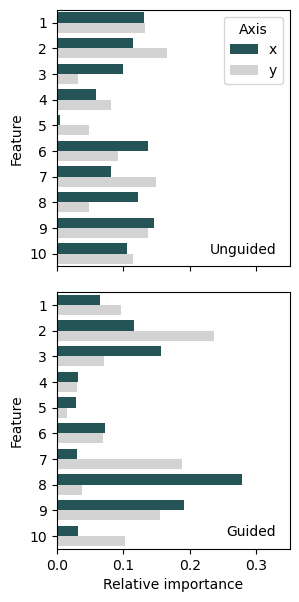

In [17]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 7))

pd_palette = paradime.utils.plotting.get_color_palette()
palette = [pd_palette["petrol"], "lightgrey"]

sns.barplot(
    data=df[~df["Guided"]],
    y="Feature",
    x="Importance",
    hue="Axis",
    palette=palette,
    estimator=lambda x: abs(np.mean(x)),
    ci=None,
    ax=ax1,
)
ax1.set_xlabel("")
ax1.set_xticklabels("")
ax1.set_xlim(0, 0.35)
ax1.text(0.33, 9.0, "Unguided", ha="right")

sns.barplot(
    data=df[df["Guided"]],
    y="Feature",
    x="Importance",
    hue="Axis",
    palette=palette,
    estimator=lambda x: abs(np.mean(x)),
    ci=None,
    ax=ax2,
)
ax2.legend()
ax2.set_xlabel("Relative importance")
ax2.set_xlim(0, 0.35)

ax2.legend([],[], frameon=False)
ax2.text(0.33, 9.0, "Guided", ha="right")

fig.subplots_adjust(hspace=0.1)

fig.savefig("guided-bar.pdf", bbox_inches = "tight")

From these bar charts we can indeed conclude that the feature importance of the selected feature has increased substantially for the _x_-axis, but not changed much for the _y_-axis.